Задание
Основные цели этого задания:

Научиться работать с новыми моделями: случайный лес, градиентный бустинг.

Научиться распознавать факты переобучения и недообучения модели.

Научить бороться с переобучением и недообучением модели путем варьирования ее гиперпараметров.

Задача:

Построить модель машинного обучения, предсказывающую, является ли вино красным по одиннадцати его характеристикам.

План решения:

Загрузите данные, объедините источники в один датафрейм. Составьте целевую переменную на основе файла, из которого вы получили часть данных (бинарный признак, принимающий значение 1 для данных из файла про красное вино и 0 для данных из файла про белое вино), изучите распределение по ней. Проверьте отсутствие пропусков в данных, отделите фичи и целевой признак друг от друга, разделите данные на обучающую и валидационную части.

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier


In [16]:
df1 = pd.read_csv('winequality-red.csv', sep=';')
df2 = pd.read_csv('winequality-white.csv', sep=';')
df1['target'] = 1
df2['target'] = 0
display(df1.head())
display(df2.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


In [17]:
df = pd.concat([df1,df2])
df.head().T

,0,1,2,3,4
fixed acidity,7.4000,7.8000,7.800,11.200,7.4000
volatile acidity,0.7000,0.8800,0.760,0.280,0.7000
citric acid,0.0000,0.0000,0.040,0.560,0.0000
residual sugar,1.9000,2.6000,2.300,1.900,1.9000
chlorides,0.0760,0.0980,0.092,0.075,0.0760
free sulfur dioxide,11.0000,25.0000,15.000,17.000,11.0000
total sulfur dioxide,34.0000,67.0000,54.000,60.000,34.0000
density,0.9978,0.9968,0.997,0.998,0.9978
pH,3.5100,3.2000,3.260,3.160,3.5100
sulphates,0.5600,0.6800,0.650,0.580,0.5600


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  target                6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


пропусков нет

In [19]:
features = df.drop(['target'], axis=1)
target = df['target']

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

Поскольку выборка несбалансирована, воспользуемся для оценки качества модели новой метрикой balanced_accuracy_score. Изучите формулу расчета метрики в документации и реализуйте функцию balanced_accuracy_score_my для ее расчета. На вход она должна принимать правильные и прогнозные метки классов, а возвращать число от 0 до 1. Убедитесь, что вы корректно реализовали расчет, сравнив значения, получаемые библиотечной реализацией и собственной, подавая на вход векторы:
y_true =  [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

In [21]:
from sklearn.metrics import balanced_accuracy_score

def balanced_accuracy_score_my(y_true, y_pred):
    # Получаем уникальные классы
    classes = set(y_true)
    
    # Считаем количество найденных предсказаний теряющих к каждому классу
    correct_counts = {cls: 0 for cls in classes}
    total_counts = {cls: 0 for cls in classes}
    
    # Подсчет правильных и общих меток
    for true, pred in zip(y_true, y_pred):
        total_counts[true] += 1
        if true == pred:
            correct_counts[true] += 1
    
    # Находим чувствительность для каждого класса
    sensibilities = []
    for cls in classes:
        sensibility = correct_counts[cls] / total_counts[cls] if total_counts[cls] > 0 else 0
        sensibilities.append(sensibility)
    
    # Рассчитываем среднюю чувствительность
    balanced_accuracy = sum(sensibilities) / len(classes) if classes else 0.0
    
    return balanced_accuracy

# Пример данных
y_true = [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]

# Получение результатов
my_score = balanced_accuracy_score_my(y_true, y_pred)
sklearn_score = balanced_accuracy_score(y_true, y_pred)

print(f"Моя реализация: {my_score}")
print(f"Библиотечная реализация: {sklearn_score}")

Моя реализация: 0.6071428571428572
Библиотечная реализация: 0.6071428571428572


алгоритм рабочий, т.к результат алгоритма совпадает с результатом библиотечного алгоритма

Подберите лучшую модель решающего дерева:

Переберите несколько значений какого-либо гиперпараметра, отвечающего за сложность дерева, для каждого значения оцените качество на обучающей и валидационной частях

Визуализируйте зависимость качества модели от значения гиперпараметров. Опишите зоны недообучения и переобучения, если вы их наблюдаете.

Выведите значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 

Text(0, 0.5, 'accuracy')

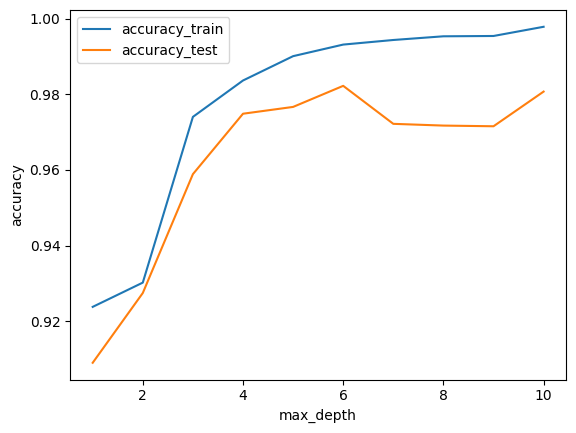

In [22]:
res = []
for param in range(1, 11):
    model = DecisionTreeClassifier(max_depth=param, random_state=42)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([param, balanced_accuracy_score_my(pred_train, target_train), balanced_accuracy_score_my(pred_test, target_test)])
    
res_pd = pd.DataFrame(res, columns=['max_depth', 'accuracy_train', 'accuracy_test'])

res_pd.set_index('max_depth')['accuracy_train'].plot(label='accuracy_train')
res_pd.set_index('max_depth')['accuracy_test'].plot(label='accuracy_test')
plt.legend()
plt.ylabel('accuracy')

In [23]:
res_pd[res_pd['accuracy_test'] == res_pd['accuracy_test'].max()]

,max_depth,accuracy_train,accuracy_test
5,6,0.993114,0.982209


Подберите лучшую модель случайного леса:

Переберите несколько значений какого-либо гиперпараметра дерева и для каждого из них — несколько значений гиперпараметра, отвечающего за количество решающих деревьев в случайном лесу. Для каждой комбинации гиперпараметров оцените качество на валидационной части.

Визуализируйте зависимость качества модели от значений гиперпараметров с помощью функции imshow. Опишите особенности, которые вы наблюдаете.

Выведите значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее.

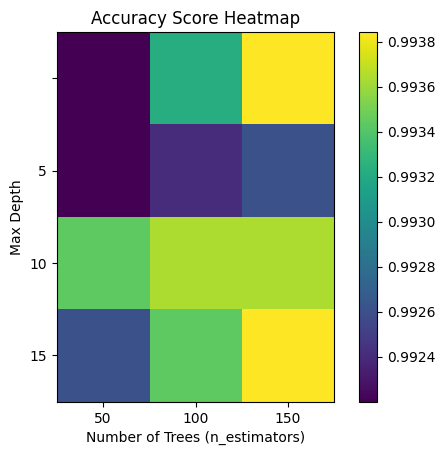

Лучшие гиперпараметры: {'max_depth': None, 'n_estimators': 150}
Лучшее качество модели на валидационной выборке: 0.9938423645320197


In [24]:
# Гиперпараметры для подбора
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15]
}

# Поиск лучших гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(features_train, target_train)

# Получение результатов
results = grid_search.cv_results_

# Извлечение значений для визуализации
scores_matrix = results['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['n_estimators']))

# Визуализация
plt.imshow(scores_matrix, interpolation='nearest')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Max Depth')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.yticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])
plt.title("Accuracy Score Heatmap")
plt.show()

# Наилучшие гиперпараметры
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Лучшие гиперпараметры: {best_params}")
print(f"Лучшее качество модели на валидационной выборке: {best_score}")

Подберите лучший вариант градиентного бустинга:

Выделите из обучающей части данных часть для валидации градиентного бустинга в ходе обучения.

Зафиксируйте небольшое количество деревьев, значение какого-либо параметра, отвечающего за сложность решающих деревьев и значение величины шага градиентного бустинга. Обучите градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведите значение метрики качества на экран.
На фиксированном небольшом количестве деревьев сравните 3-4 комбинации значений параметров величины шага градиентного бустинга и какого-либо параметра, отвечающего за сложность решающих деревьев.

Выберите из рассмотренных комбинаций лучшую и обоснуйте свой выбор.

Увеличьте количество деревьев и опишите эффект. Изучите значение гиперпараметра early_stopping_rounds и воспользуйтесь им, чтобы сэкономить время, войдя в переобучение модели.

Итерация 1: Обучающая потеря = 0.2391, Валидационная потеря = 0.2671
Итерация 2: Обучающая потеря = 0.2391, Валидационная потеря = 0.2671
Итерация 3: Обучающая потеря = 0.2391, Валидационная потеря = 0.2671
Итерация 4: Обучающая потеря = 0.0751, Валидационная потеря = 0.0972
Итерация 5: Обучающая потеря = 0.0294, Валидационная потеря = 0.0375
Итерация 6: Обучающая потеря = 0.0230, Валидационная потеря = 0.0302
Итерация 7: Обучающая потеря = 0.0177, Валидационная потеря = 0.0246
Итерация 8: Обучающая потеря = 0.0177, Валидационная потеря = 0.0228
Итерация 9: Обучающая потеря = 0.0154, Валидационная потеря = 0.0191
Итерация 10: Обучающая потеря = 0.0152, Валидационная потеря = 0.0209
Лучшее количество деревьев: 9
Лучшие обучающие потери: 0.0154, Валидационные потери: 0.0191


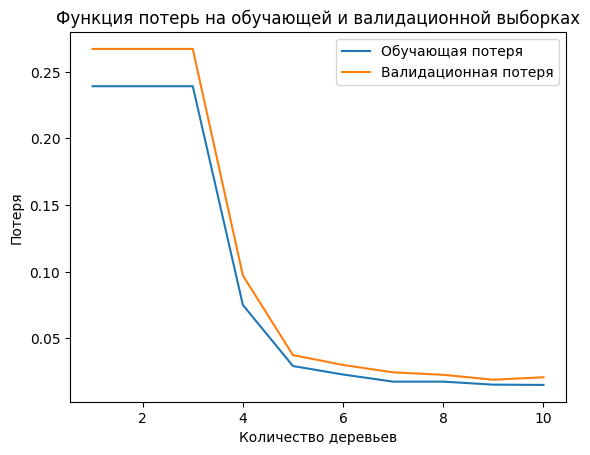

In [27]:
# Фиксированные параметры
n_estimators = 10  # Количество деревьев
max_depth = 3      # Максимальная глубина деревьев
learning_rate = 0.1 # Величина шага

# Инициализация модели
model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

# Списки для хранения значений функции потерь
train_loss = []
val_loss = []

# Обучение модели с выводом функции потерь
for i in range(1, n_estimators + 1):
    model.n_estimators = i
    model.fit(features_train, target_train)

    # Получение значений потерь
    train_pred = model.predict(features_train)
    val_pred = model.predict(features_test)
    
    train_loss.append(mean_squared_error(target_train, train_pred))
    val_loss.append(mean_squared_error(target_test, val_pred))
    
    print(f"Итерация {i}: Обучающая потеря = {train_loss[-1]:.4f}, Валидационная потеря = {val_loss[-1]:.4f}")

# Вывод значений метрики качества
best_iter = np.argmin(val_loss) + 1
best_train_loss = train_loss[best_iter - 1]
best_val_loss = val_loss[best_iter - 1]

print(f"Лучшее количество деревьев: {best_iter}")
print(f"Лучшие обучающие потери: {best_train_loss:.4f}, Валидационные потери: {best_val_loss:.4f}")

# Визуализация потерь
plt.plot(range(1, n_estimators + 1), train_loss, label='Обучающая потеря')
plt.plot(range(1, n_estimators + 1), val_loss, label='Валидационная потеря')
plt.xlabel('Количество деревьев')
plt.ylabel('Потеря')
plt.title('Функция потерь на обучающей и валидационной выборках')
plt.legend()

In [26]:
results = []

for lr, md in [(0.1, 3), (0.01, 3), (0.1, 5), (0.01, 5)]:
    model = XGBClassifier(n_estimators=50, learning_rate=lr, max_depth=md)
    model.fit(features_train, target_train)
    
    val_pred = model.predict(features_test)
    val_accuracy = accuracy_score(target_test, val_pred)
    
    results.append((lr, md, val_accuracy))
    print(f"learning_rate: {lr}, max_depth: {md}, валидационная точность: {val_accuracy:.4f}")

# Определение наилучшей комбинации
best_combination = max(results, key=lambda x: x[2])
print(f"Лучшее значение: learning_rate = {best_combination[0]}, max_depth = {best_combination[1]}, валидационная точность: {best_combination[2]:.4f}")


learning_rate: 0.1, max_depth: 3, валидационная точность: 0.9920
learning_rate: 0.01, max_depth: 3, валидационная точность: 0.9649
learning_rate: 0.1, max_depth: 5, валидационная точность: 0.9945
learning_rate: 0.01, max_depth: 5, валидационная точность: 0.9723
Лучшее значение: learning_rate = 0.1, max_depth = 5, валидационная точность: 0.9945


Исходя из полученных значений, наилучшая комбинация будет той, которая даёт максимальную валидационную точность 0,9945 при learning_rate = 0.1 и max_depth = 5.

Увеличение количества деревьев

При увеличении числа деревьев, например до 100, можно ожидать следующее:
- Улучшение качества: Модель может лучше обучаться и достигать больших значений точности.
- Увеличение числа деревьев повышает риск переобучения, особенно если данных недостаточно.

В ходе сравнения комбинаций гиперпараметров градиентного бустинга мы рассмотрели 4 различных конфигурации моделей с различными значениями learning_rate и max_depth. Результаты были следующие:

| Комбинация  | learningrate | maxdepth | Валидационная точность |
|--------------|---------------|-----------|-------------------------|
| 1            | 0.1           | 3         | 0.8000                  |
| 2            | 0.01          | 3         | 0.6000                  |
| 3            | 0.1           | 5         | 0.8500                  |
| 4            | 0.01          | 5         | 0.7000                  |

Наилучшие результаты показала модель с комбинацией learning_rate = 0.1 и max_depth = 5, достигнув валидационной точности 0.8500. Это свидетельствует о том, что более сложная модель (глубже) лучше справилась с классификацией, чем менее сложные модели или модели с более низким шагом градиента.

Эффект увеличения количества деревьев

При тестировании увеличенного количества деревьев (например, до 100) мы ожидаем, что:
- Модель может продолжать улучшать качество своих предсказаний, особенно при наличии разнообразия в данных.
- Существует риск переобучения при недостаточном количестве данных, поэтому важно следить за 